In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('./utils')
sys.path.append('./utils/APIs')

import matplotlib.pyplot as plt
import torch
import timm
import argparse
from Config import config
from utils.common import read_from_file, save_model, write_to_file, train_val_split
from utils.DataProcess import Processor
from Trainer import Trainer
from PreTrainer import PreTrainer
from Models.mamba.models_insect import build_vssm_models_ as mamba_model
from Models.OTEModel import Model

In [2]:
# args
# 训练模型
do_train = True
# 预测测试集数据
do_test = True
# 已经训练好的模型路径
load_model_path = './save_models/CMAT/pytorch_model.bin'
# 设置学习率
lr = 3e-6
# 设置权重衰减
weight_decay = 1e-2
# 设置训练轮数
epoch = 20
# 文本分析模型
text_pretrained_model = 'huawei-noah/TinyBERT_General_4L_312D'
cv_pretrained_model = 'WAVM'
# 融合模型类别
fuse_model_type = 'CMAT'
# 仅用文本预测
text_only = False
# 仅用图像预测
img_only = False

config.learning_rate = lr
config.weight_decay = weight_decay
config.epoch = epoch
config.bert_name = text_pretrained_model
config.resnet_name = cv_pretrained_model
config.fuse_model_type = fuse_model_type
config.load_model_path = load_model_path
config.only = 'img' if img_only else None
config.only = 'text' if text_only else None
if img_only and text_only: config.only = None
print('TextModel: {}, ImageModel: {}, FuseModel: {}'.format(config.bert_name,config.resnet_name, config.fuse_model_type))

TextModel: huawei-noah/TinyBERT_General_4L_312D, ImageModel: WAVM, FuseModel: CMAT


In [3]:
# Initilaztion
processor = Processor(config)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# PreTrain
dataset_file_path = '../dataset/CornDataset/csv/train/train_data.csv'
data = read_from_file(dataset_file_path)
train_data, val_data = train_val_split(data)
train_loader = processor(train_data, config.train_params, 'train')
val_loader = processor(val_data, config.val_params, 'train')
# preModel = Model(config)
# preTrainer = PreTrainer(config, processor, preModel, device)
# best_lr = preTrainer.train_to_get_best_lr(train_loader)
# config.learning_rate = best_lr
config.learning_rate = 8.05755185e-06

----- [Loading]


In [ ]:
model = Model(config)
trainer = Trainer(config, processor, model, device)

In [ ]:
plt_train_loss = []
plt_val_loss = []

In [ ]:
# Train
def train():
    best_acc = 0
    epoch = config.epoch
    for e in range(epoch):
        print('-' * 20 + ' ' + 'Epoch ' + str(e+1) + ' ' + '-' * 20)
        tloss = trainer.train(train_loader)
        plt_train_loss.append(tloss)
        print('Train Loss: {}'.format(tloss))
        vloss, vacc = trainer.valid(val_loader)
        plt_val_loss.append(vloss)
        print('Valid Loss: {}'.format(vloss))
        print('Valid Acc: {}'.format(vacc))
        if vacc > best_acc:
            best_acc = vacc
            save_path = './save_models'
            save_model(save_path, config.fuse_model_type, model)
            print('Update best model!')
        print()
    # plt
    train_loss_y = plt_train_loss
    train_loss_x = range(len(plt_train_loss))

    val_loss_y = plt_val_loss
    val_loss_x = range(len(plt_val_loss))

    plt.figure()

    # 去除顶部和右边框框
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xlabel('iters')    # x轴标签
    plt.ylabel('loss')     # y轴标签

    # 以x_train_loss为横坐标，y_train_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
    # 默认颜色，如果想更改颜色，可以增加参数color='red',这是红色。
    plt.plot(train_loss_x, train_loss_y, linewidth=1, linestyle="solid", label="train loss")
    plt.plot(val_loss_x, val_loss_y, linewidth=1, linestyle="solid", label="val loss")
    plt.legend()
    plt.title('Loss curve')
    plt.show()

In [ ]:
# Test
def test():
    test_file_path = '../dataset/CornDataset/csv/test/test_data.csv'
    test_data = read_from_file(test_file_path)
    test_loader = processor(test_data, config.test_params,'test')

    # if config.load_model_path is not None:
    #     model.load_state_dict(torch.load(config.load_model_path))

    outputs = trainer.predict(test_loader)
    write_to_file(test_file_path, outputs)

In [ ]:
# main
if __name__ == "__main__":
    if do_train:
        train()
    
    if do_test:
        if load_model_path is None and not do_train:
            print('请输入已训练好模型的路径load_model_path或者选择添加do_train arg')
        else:
            test()

In [11]:
print(plt_train_loss)
print(plt_val_loss)

[0.64618, 0.43786, 0.39237, 0.34971, 0.31698, 0.29139, 0.26818, 0.24559, 0.2248, 0.20444, 0.17151, 0.15603, 0.1339, 0.11092, 0.07885, 0.06407, 0.049, 0.0383, 0.03182, 0.02743]
[0.4188181469817796, 0.37049140219616716, 0.3629708264225854, 0.3283027316398558, 0.3438220054952688, 0.31765131318631273, 0.2799587783814278, 0.32727720314431535, 0.2850036663779368, 0.281796929152039, 0.2933321466083608, 0.2743152295979696, 0.24711302182354253, 0.27854052399722007, 0.249321628997374, 0.3206514779838041, 0.2553330751801578, 0.2935778794535411, 0.34996797638829963, 0.37840689977903863]


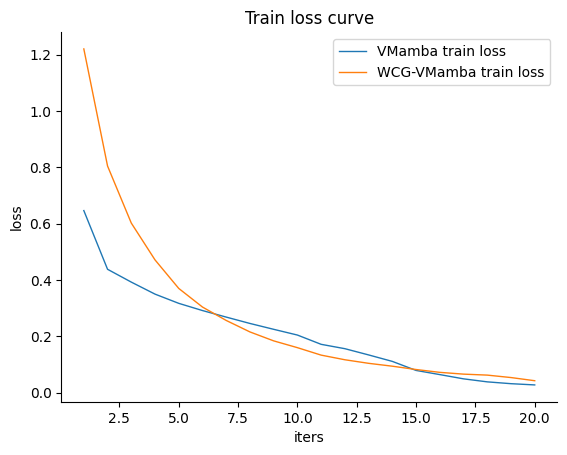

In [4]:
# plt
train_VMamba_loss_y = [0.64618, 0.43786, 0.39237, 0.34971, 0.31698, 0.29139, 0.26818, 0.24559, 0.2248, 0.20444, 0.17151, 0.15603, 0.1339, 0.11092, 0.07885, 0.06407, 0.049, 0.0383, 0.03182, 0.02743]
train_loss_x = []
for i in range(1,epoch + 1):
    train_loss_x.append(i)

train_WCGVMamba_loss_y = [1.22, 0.80433, 0.60191, 0.47116, 0.3699, 0.30382, 0.25626, 0.21551, 0.18376, 0.15969, 0.1332, 0.11675, 0.1041, 0.09389, 0.08209, 0.07203, 0.06573, 0.06225, 0.05357, 0.04234]

plt.figure()

# 去除顶部和右边框框
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('iters')    # x轴标签
plt.ylabel('loss')     # y轴标签

# 以x_train_loss为横坐标，y_train_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
# 默认颜色，如果想更改颜色，可以增加参数color='red',这是红色。
plt.plot(train_loss_x, train_VMamba_loss_y, linewidth=1, linestyle="solid", label="VMamba train loss")
plt.plot(train_loss_x, train_WCGVMamba_loss_y, linewidth=1, linestyle="solid", label="WCG-VMamba train loss")
plt.legend()
plt.title('Train loss curve')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (0,) and (20,)

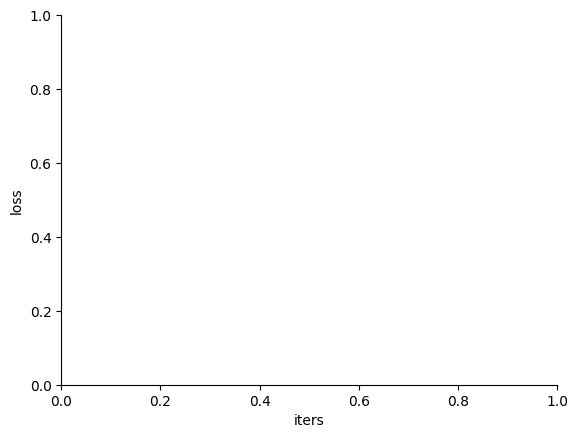

In [5]:
# plt
val_VMamba_loss_y = [0.4188181469817796, 0.37049140219616716, 0.3629708264225854, 0.3283027316398558, 0.3438220054952688, 0.31765131318631273, 0.2799587783814278, 0.32727720314431535, 0.2850036663779368, 0.281796929152039, 0.2933321466083608, 0.2743152295979696, 0.24711302182354253, 0.27854052399722007, 0.249321628997374, 0.3206514779838041, 0.2553330751801578, 0.2935778794535411, 0.34996797638829963, 0.37840689977903863]
val_loss_x = []
for i in range(1,epoch + 1):
    val_loss_x.append(i)

val_WCGVMamba_loss_y = [0.7923009844236476, 0.5165205291842901, 0.34067295347490617, 0.261572460093165, 0.21134478394542972, 0.1845078428666438, 0.16548796430710824, 0.17858504463908492, 0.15031907751515347, 0.15463309233347255, 0.14605470890960387, 0.13259167868083202, 0.14913691986872946, 0.1385477246736647, 0.1399659426201896, 0.15046217198914258, 0.1265443248113477, 0.12911968296193468, 0.1320269356446681, 0.13400556961254728]

plt.figure()

# 去除顶部和右边框框
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('iters')    # x轴标签
plt.ylabel('loss')     # y轴标签

# 以x_train_loss为横坐标，y_train_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
# 默认颜色，如果想更改颜色，可以增加参数color='red',这是红色。
plt.plot(val_loss_x, val_VMamba_loss_y, linewidth=1, linestyle="solid", label="VMamba train loss")
plt.plot(val_loss_x, val_WCGVMamba_loss_y, linewidth=1, linestyle="solid", label="WCG-VMamba train loss")
plt.legend()
plt.title('Val loss curve')
plt.show()